In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Reading and investigating the data

In [2]:
data = pd.read_csv('bankdata.csv')

In [3]:
data.shape

(74364, 9)

In [4]:
data.dtypes

type             object
operation        object
amount_total    float64
balance         float64
k_symbol         object
amount_left       int64
duration          int64
payments        float64
status           object
dtype: object

In [5]:
data.head()

,type,operation,amount_total,balance,k_symbol,amount_left,duration,payments,status
0,PRIJEM,prevod,44749.0,45549.0,unknown,79608,24,3317.0,A
1,PRIJEM,vklad,1000.0,1000.0,unknown,52788,12,4399.0,A
2,PRIJEM,vklad,1100.0,1100.0,unknown,21924,36,609.0,A
3,PRIJEM,vklad,700.0,700.0,unknown,23052,12,1921.0,A
4,PRIJEM,vklad,900.0,900.0,unknown,41904,12,3492.0,A


In [6]:
data['status'].value_counts()

A    64599
B     9765
Name: status, dtype: int64

### Investigating the numerical variables

In [7]:
data.describe()

,amount_total,balance,amount_left,duration,payments
count,74364.000000,74364.000000,74364.000000,74364.000000,74364.000000
mean,7832.649125,46022.153061,102745.132645,23.942230,4356.580832
std,11729.040391,25439.948570,74749.275498,12.155783,2205.840892
min,0.000000,-14137.200000,4980.000000,12.000000,319.000000
25%,144.300000,27675.125000,46320.000000,12.000000,2569.000000
50%,3000.000000,40965.150000,86184.000000,24.000000,4051.000000
75%,9868.500000,60098.550000,140400.000000,36.000000,6315.000000
max,87300.000000,193910.000000,464520.000000,60.000000,9736.000000


#### Investigating variable duration

In [8]:
data['duration'].value_counts()

12    28761
24    25155
36    14110
48     4721
60     1617
Name: duration, dtype: int64

In [9]:
# we will convert this to a categorical
data['duration'] = data['duration'].apply(str)

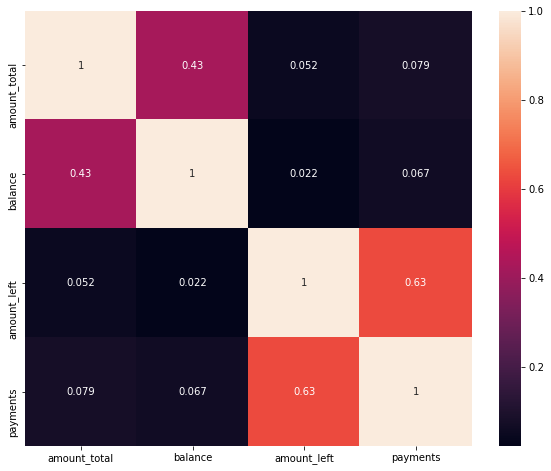

In [10]:
# Checking for multicollinearity
plt.figure(figsize=(10, 8))
ax = sns.heatmap(data.corr(), annot=True)
plt.show()

payments and amount_left have a rather high correlation, so we will include only one of them in the model

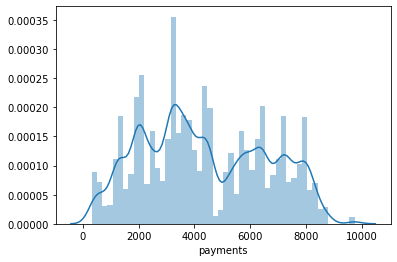

In [11]:
#sns.distplot(data['amount_total'])
#plt.show()

#sns.distplot(data['balance'])
#plt.show()

sns.distplot(data['payments'])
plt.show()

### Preprocessing the numerical variables

In [12]:
from sklearn.preprocessing import StandardScaler
data_num = data.select_dtypes(include = np.number).drop(columns = 'amount_left')
print(data_num.head())
# Standardizing data
transformer = StandardScaler().fit(data_num)
data_num_standardized = transformer.transform(data_num)
x = pd.DataFrame(data_num_standardized, columns = data_num.columns)
print(x.head())

   amount_total  balance  payments
0       44749.0  45549.0    3317.0
1        1000.0   1000.0    4399.0
2        1100.0   1100.0     609.0
3         700.0    700.0    1921.0
4         900.0    900.0    3492.0
   amount_total   balance  payments
0      3.147453 -0.018599 -0.471289
1     -0.582545 -1.769754  0.019231
2     -0.574019 -1.765823 -1.698947
3     -0.608123 -1.781547 -1.104158
4     -0.591071 -1.773685 -0.391953


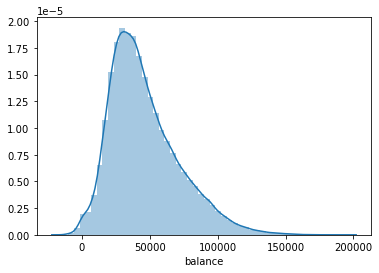

In [13]:
sns.distplot(data['balance'])
plt.show()

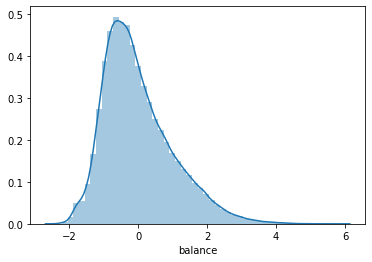

In [14]:
sns.distplot(x['balance'])
plt.show()

### Getting dummies for the categorical variables

In [15]:
from sklearn.preprocessing import OneHotEncoder
cat = data.select_dtypes(include = np.object).drop(columns = 'status')
enc = OneHotEncoder()
categorical = pd.DataFrame(enc.fit_transform(cat).toarray(), columns = enc.get_feature_names())
categorical.head()

,x0_PRIJEM,x0_VYBER,x0_VYDAJ,x1_prevod,x1_unknown,x1_vklad,x1_vyber,x2_pojistne,x2_sankc. urok,x2_sipo,x2_sluzby,x2_unknown,x2_urok,x2_uver,x3_12,x3_24,x3_36,x3_48,x3_60
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [16]:
categorical.sum(axis = 1)

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
74359    4.0
74360    4.0
74361    4.0
74362    4.0
74363    4.0
Length: 74364, dtype: float64

In [17]:
y = data['status']
X = pd.concat((x, categorical), axis=1)
X.head()

,amount_total,balance,payments,x0_PRIJEM,x0_VYBER,x0_VYDAJ,x1_prevod,x1_unknown,x1_vklad,x1_vyber,...,x2_sipo,x2_sluzby,x2_unknown,x2_urok,x2_uver,x3_12,x3_24,x3_36,x3_48,x3_60
0,3.147453,-0.018599,-0.471289,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.582545,-1.769754,0.019231,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.574019,-1.765823,-1.698947,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.608123,-1.781547,-1.104158,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.591071,-1.773685,-0.391953,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Splitting into train and test set

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
logisticr = LogisticRegression(max_iter = 500).fit(X_train, y_train)

In [20]:
predictions = logisticr.predict(X_test)
logisticr.score(X_test, y_test)

0.8806226047199623

In [21]:
y_test.value_counts()

A    25839
B     3907
Name: status, dtype: int64

In [22]:
pd.Series(predictions).value_counts()

A    29118
B      628
dtype: int64

What happened in terms of the classes?

### Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier().fit(X_train, y_train)

In [24]:
predictions = decisiontree.predict(X_test)
decisiontree.score(X_test, y_test)

0.9946883614603644

In [25]:
pd.Series(predictions).value_counts()

A    25819
B     3927
dtype: int64

In [26]:
decisiontree.feature_importances_

array([1.43168285e-02, 1.23826017e-01, 6.53555100e-01, 1.53276631e-03,
       5.84855729e-04, 2.32896616e-04, 1.81199037e-03, 7.52178065e-04,
       1.64264348e-03, 7.05166672e-04, 4.77936035e-04, 0.00000000e+00,
       5.19590488e-04, 0.00000000e+00, 4.97816516e-04, 7.79088219e-04,
       0.00000000e+00, 7.86200775e-02, 7.79198233e-02, 1.45125491e-02,
       9.69774718e-03, 1.80149280e-02])

In [30]:
print(pd.Series(dict(zip(X.columns, decisiontree.feature_importances_))))

amount_total      0.014317
balance           0.123826
payments          0.653555
x0_PRIJEM         0.001533
x0_VYBER          0.000585
x0_VYDAJ          0.000233
x1_prevod         0.001812
x1_unknown        0.000752
x1_vklad          0.001643
x1_vyber          0.000705
x2_pojistne       0.000478
x2_sankc. urok    0.000000
x2_sipo           0.000520
x2_sluzby         0.000000
x2_unknown        0.000498
x2_urok           0.000779
x2_uver           0.000000
x3_12             0.078620
x3_24             0.077920
x3_36             0.014513
x3_48             0.009698
x3_60             0.018015
dtype: float64


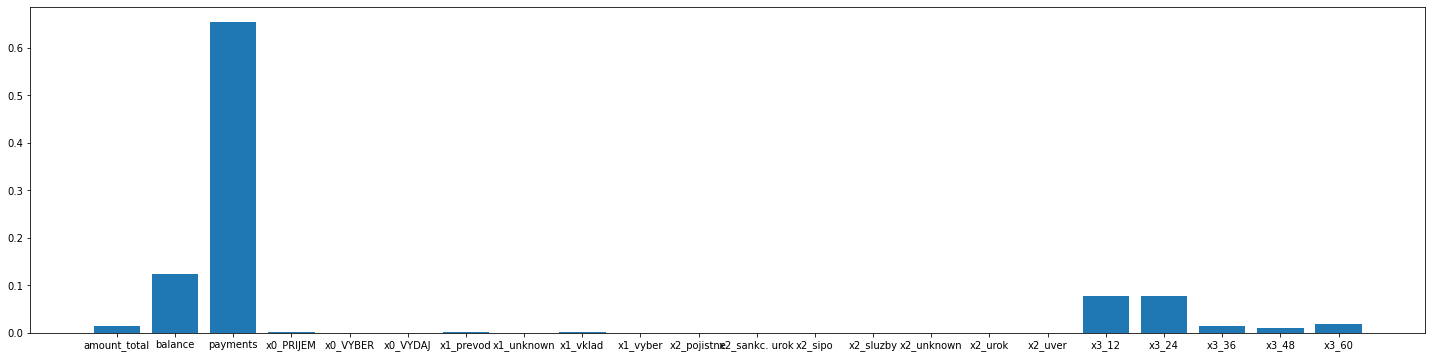

In [31]:
plt.rcParams['figure.figsize'] = [25, 6]
plt.bar(height = decisiontree.feature_importances_, x = X.columns)
plt.show()

## SVM

In [32]:
from sklearn.svm import SVC

svm = SVC().fit(X_train, y_train)
predictions = svm.predict(X_test)
print(svm.score(X_test, y_test))
print(pd.Series(predictions).value_counts())

0.8984737443689907
A    28611
B     1135
dtype: int64


## K-Nearest Neighbors

In [36]:
from sklearn.neighbors import KNeighborsClassifier

nearest_neighbors = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)
predictions = nearest_neighbors.predict(X_test)
print(nearest_neighbors.score(X_test, y_test))
print(pd.Series(predictions).value_counts())

0.9308142271229746
A    27187
B     2559
dtype: int64


In [34]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.NeighborsBase, sklearn.neighbors._base.KNeighborsMixin, sklearn.neighbors._base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'} or callable, default='uniform'
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of t

# Supervised Learning: Regression

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
# SVR
from sklearn.svm import SVR
# KNN
from sklearn.neighbors import KNeighborsRegressor